In [1]:
# Basic system and data packages
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

In [3]:
df = pd.read_csv('../../../data/emissions-projection/emissions-populations-dvmt.csv')
#Plot the data set
df

# Drop the first column
df = df.drop(columns=['Unnamed: 0'])

# Set the second column as the row index
df = df.set_index('Year')

,Mobile GHG Emissions (MMTCO2e),Agriculture GHG Emissions (MMTCO2e),Commercial GHG Emissions (MMTCO2e),Electricity GHG Emissions (MMTCO2e),Industrial GHG Emissions (MMTCO2e),Residential GHG Emissions (MMTCO2e),Solidwaste GHG Emissions (MMTCO2e),Wastewater GHG Emissions (MMTCO2e),Population,DVMT (Miles)
Year,,,,,,,,,,
1990,15.120625,0.375261,3.828568,11.908703,3.001041,8.279021,1.065912,0.359842,3289056,72072000
1991,15.005884,0.348502,3.662331,12.015808,3.100758,8.024783,1.113482,0.361827,3288640,72948000
1992,15.086747,0.389088,4.312955,11.282676,3.355918,9.505435,1.242805,0.362378,3274997,72293000
1993,15.146864,0.415000,3.843474,10.228667,3.447719,9.081525,1.209374,0.363307,3272325,74025000
1994,15.066461,0.408122,4.172272,10.395885,3.150548,8.677775,1.237386,0.365658,3268346,74352000
1995,14.815692,0.400748,3.841800,10.320433,3.103303,7.977389,1.249919,0.365747,3265293,76830000
1996,15.623592,0.344938,4.133427,10.734700,3.257568,8.461561,1.268976,0.367926,3267030,76874000
1997,15.679850,0.348057,4.301810,13.201970,3.266450,8.186120,1.615209,0.368520,3268514,78202000
1998,15.917011,0.375380,4.036593,12.948870,3.119599,7.122707,1.526577,0.371087,3272563,79936000


In [19]:
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

po_train = df_train['Population']
po_test = df_test['Population']


In [20]:
# Fit the model
mod = sm.tsa.arima.ARIMA(po_train, order=(0,2,0))#exog = array of publishsed VMT. inside of the function.
#what are existing forecasting, few slides 
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:             Population   No. Observations:                   26
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -284.226
Date:                Wed, 24 Jan 2024   AIC                            570.451
Time:                        09:16:21   BIC                            571.629
Sample:                             0   HQIC                           570.764
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.042e+09   1.22e+08      8.566      0.000    8.03e+08    1.28e+09
Ljung-Box (L1) (Q):                   6.31   Jarque-Bera (JB):                72.19
Prob(Q):                              0.01   Pr

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
import itertools

# Define the range of values for p, d, and q
p_values = range(3)  # Adjust the range based on your preferences
d_values = range(3)
q_values = range(3)

# Initialize a list to store the orders and corresponding AIC and BIC values
order_aic_bic_list = []

# Loop through all combinations of p, d, and q
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Fit the model for the current combination
        mod = sm.tsa.arima.ARIMA(po_train, order=(p, d, q))
        res = mod.fit()

        # Store the order, AIC, and BIC values in the list
        order_aic_bic_list.append(((p, d, q), res.aic, res.bic))

    except Exception as e:
        # Handle any exceptions that might occur during model fitting
        print(f"Issue with order ({p}, {d}, {q}): {e}")

# Sort the list based on AIC values
order_aic_bic_list.sort(key=lambda x: (x[1], x[2]))

# Print the first five best orders and corresponding AIC and BIC values
for i, (order, aic, bic) in enumerate(order_aic_bic_list[:5]):
    print(f"Rank {i + 1} - Order: {order}, AIC: {aic}, BIC: {bic}")


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

Rank 1 - Order: (0, 2, 0), AIC: 570.4510599619798, BIC: 571.6291137923278
Rank 2 - Order: (0, 2, 1), AIC: 572.7230333953457, BIC: 575.0791410560416
Rank 3 - Order: (1, 2, 0), AIC: 572.9704768829961, BIC: 575.326584543692
Rank 4 - Order: (1, 2, 1), AIC: 573.8379767874906, BIC: 577.3721382785344
Rank 5 - Order: (0, 2, 2), AIC: 574.106310447371, BIC: 577.6404719384149


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

In [71]:
# Forecast on training data
train_forecast = res.get_prediction(start=0, end=len(po_train)-1)
train_forecast_mean = train_forecast.predicted_mean
train_forecast_mean_re = train_forecast_mean.drop(train_forecast_mean.index[:2], inplace=True)
train_conf_int = train_forecast.conf_int().iloc[2:]

new_index = [2016, 2017, 2018, 2019, 2020, 2021]

# Forecast on test data
test_forecast = res.get_prediction(start=len(po_train), end=len(po_train)+len(df_test)-1)
test_forecast_mean = test_forecast.predicted_mean
test_conf_int = test_forecast.conf_int()
test_conf_int.index = new_index


# Convert Series to DataFrame with the first column as the index
test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Population'])
test_forecast_df['Year'] = new_index

# Set the 'Year' column as the index
test_forecast_df.set_index('Year', inplace=True)

train_forecast_mean_re = train_forecast_mean.iloc[1:]

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the actual values for the test set
actual_values = df_test['Population']

# Extract the predicted values from the test forecast
predicted_values = test_forecast_df['Population']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


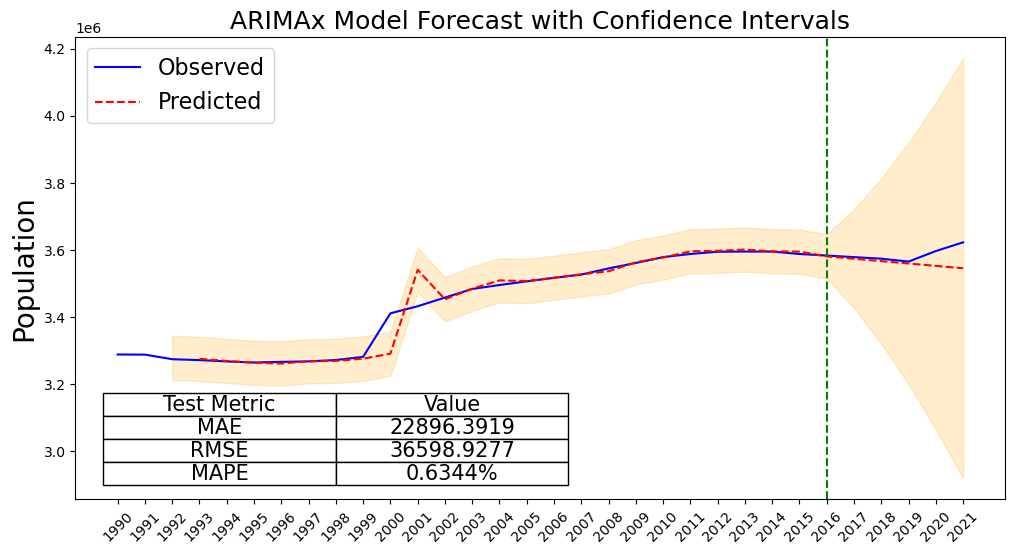

In [72]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the results with confidence bands
plt.figure(figsize=(12, 6))

#combine the test and train data together
concatenated_observed = pd.concat([po_train,po_test])

#combine the predicted test and train data together
concatenated_predicted = pd.concat([train_forecast_mean_re, test_forecast_df['Population']])

#combine the confidence interval of train and test data
concatenated_interval = pd.concat([train_conf_int, test_conf_int])


#plot the observed value
plt.plot(concatenated_observed.index, concatenated_observed, label='Observed', color='blue')


#plot the predicted value
plt.plot(concatenated_predicted.index, concatenated_predicted, label='Predicted', color='red', linestyle='--')



# Plot confidence bands for training data
plt.fill_between(concatenated_interval.index, concatenated_interval.iloc[:, 0], concatenated_interval.iloc[:, 1], color='orange', alpha=0.2)

#combine the index
combined_index = np.concatenate([po_train.index, test_forecast_df.index])

plt.title('ARIMAx Model Forecast with Confidence Intervals', fontsize=18)
# Adjust x-axis ticks and labels
plt.xticks(combined_index, rotation=45)

#plt.xlabel('Time', fontsize=16)
plt.ylabel('Population', fontsize=20)
plt.legend(fontsize=16)

# Set x-axis and y-axis tick labels with fontsize
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=2016, color='green', linestyle='--', label='Year 2016 (X-axis)')

#create a table to show the MAE and RMSE

# Create a table inside the plot
table_data = [['Test Metric', 'Value'], 
              ['MAE', f'{mae:.4f}'], 
              ['RMSE', f'{rmse:.4f}'], 
              ['MAPE', f'{mape:.4f}%']]
table = plt.table(cellText=table_data, loc='lower left', cellLoc='center', bbox=[0.03, 0.03, 0.5, 0.2], colWidths=[0.2, 0.2, 0.8, 0.8])

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(15)  # Adjust the font size as needed


plt.savefig('../../../figures/Report-images/arimax-population-vmt.png', dpi=600, bbox_inches='tight')

In [92]:
extended_index = list(range(2022, 2051))

extended_forecast = res.get_forecast(steps=len(extended_index))
extended_forecast_mean = extended_forecast.predicted_mean

extended_conf_int = extended_forecast.conf_int()
extended_conf_int.index = extended_index

extended_forecast_df = pd.DataFrame({'Year': extended_index, 'Population': extended_forecast_mean.values})
extended_forecast_df.set_index('Year', inplace=True)
exog_po = extended_forecast_df

# Assuming you have a DataFrame named 'extended_forecast_df'
exog_po.to_csv('../../../results/population-forecast-2022to2050.csv', index=True)

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [93]:
exog_po

,Population
Year,
2022,3.581440e+06
2023,3.574350e+06
2024,3.567261e+06
2025,3.560171e+06
2026,3.553081e+06
2027,3.545992e+06
2028,3.538902e+06
2029,3.531813e+06
2030,3.524723e+06
